<a href="https://colab.research.google.com/github/SikanderBinMukaram/ImageReconstructionAutoEncoder/blob/main/ImageReconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# **Reconstruction of images using Autoencoder**





##Imports

In [1]:
#imports
import os
import torch
import gdown 
import torchvision
import numpy as np
from torch import nn
from tqdm import tqdm
!pip install pytorch_msssim
from pytorch_msssim import ssim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.datasets import CIFAR10
from torch.utils.data.sampler import SubsetRandomSampler
from skimage.metrics import structural_similarity as ssimm
import cv2
from google.colab.patches import cv2_imshow



In [ ]:
# os.environ["CUDA_VISIBLE_DEVICES"]="1" #using specific gpu

In [2]:
#Directory for saving intermediate images & models
if not os.path.exists('./reconstruction'):
    os.mkdir('./reconstruction')

##Model 
An autoencoder.

In [3]:
#Model & Functions

#image values are clamped in range of 0 & 1 to get rid of negative values 
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 32, 32)
    return x




class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        #Encoder
        self.conv_1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.batchNorm1 = nn.BatchNorm2d(32)

        self.conv_2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.batchNorm2 = nn.BatchNorm2d(64)

        self.conv_3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.batchNorm3 = nn.BatchNorm2d(128)

        self.conv_4 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.batchNorm4 = nn.BatchNorm2d(256)

        self.conv_5 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.batchNorm5 = nn.BatchNorm2d(256)

        #Decoder
        self.deconv_1 = nn.ConvTranspose2d(256, 256, 3, stride=2, padding=1, output_padding=1)
        self.batchNorm1_d = nn.BatchNorm2d(256)
        
        self.deconv_2 = nn.ConvTranspose2d(256+128, 128, 3, stride=2, padding=1, output_padding=1)
        self.batchNorm2_d = nn.BatchNorm2d(128)
        
        self.deconv_3 = nn.ConvTranspose2d(128+64, 64, 3, stride=2, padding=1, output_padding=1)
        self.batchNorm3_d = nn.BatchNorm2d(64)
        
        self.deconv_4 = nn.ConvTranspose2d(64+32, 32, 3, stride=2, padding=1, output_padding=1)
        self.batchNorm4_d = nn.BatchNorm2d(32)
        
        self.deconv_5 = nn.ConvTranspose2d(32, 3, 3,  padding=1)


    def forward(self, x):
       conv_b1 = F.relu(self.batchNorm1(self.conv_1(x)))
       conv_b2 = F.relu(self.batchNorm2(self.conv_2(conv_b1)))
       conv_b3 = F.relu(self.batchNorm3(self.conv_3(conv_b2)))
       conv_b4 = F.relu(self.batchNorm4(self.conv_4(conv_b3)))
       conv_b5 = F.relu(self.batchNorm5(self.conv_5(conv_b4)))

       deconv_b1 = F.relu(self.batchNorm1_d(self.deconv_1(conv_b5)))
       concat_1 = torch.cat((deconv_b1, conv_b3),1)
       
       deconv_b2 = F.relu(self.batchNorm2_d(self.deconv_2(concat_1)))
       concat_2 = torch.cat((deconv_b2, conv_b2),1)

       deconv_b3 = F.relu(self.batchNorm3_d(self.deconv_3(concat_2)))
       concat_3 = torch.cat((deconv_b3, conv_b1),1)

       deconv_b4 = F.relu(self.batchNorm4_d(self.deconv_4(concat_3)))

       deconv_b5 = F.tanh(  self.deconv_5(deconv_b4))
              
       return deconv_b5







##Function for Evaluation and Validation

In [42]:

# pass true when testing else false for validation
def Evaluate(dataloader_, model, isTest):

  MSE = nn.MSELoss()  #define mean square error loss

  sample_idx = 0      # samples to store or show
  total_mse = 0       # total mse error
  total_ssim = 0      # total structure similarity error
  total_psnr = 0      # total PSNR error

  for data in tqdm(dataloader_, position=0, leave=True):

      batch, _ = data       # Get a batch
      batch = (batch).cuda()

      # ===================forward=====================
      # with torch.no_grad():
      output = model(batch)   #we get output from the model which will be used for evaluation

      #Normalise the images to have positive values between 0 & 1
      out = to_img(output.cpu().data)
      inp  = to_img(batch.cpu().data)

            

      #MSE 
      mse = MSE(out,inp)

      #PSNR
      psnr = 10 * torch.log10(1 / mse)
      

      #SSIM -  for ssim, I had to make changes to the dimensions in 
      #order to use the ssim function provided by skimage.metrics
      out = np.moveaxis(np.squeeze(out.detach().numpy()), 0, -1)
      inp = np.moveaxis(np.squeeze(inp.detach().numpy()), 0, -1)
      ssim = ssimm(out, inp, multichannel=True)
            
      total_mse += mse
      total_psnr+= psnr 
      total_ssim+= ssim

      if isTest:
        #save & show samples for evaluation
        sample_idx+=1
        if sample_idx % 500 == 0:
          out = torch.cat((batch,output),0)
          out = to_img(out.cpu().data)
          save_image(out, './reconstruction/Test_image_out1_{}.png'.format(sample_idx))
          example = cv2.imread('./reconstruction/Test_image_out1_{}.png'.format(sample_idx), cv2.IMREAD_UNCHANGED)
          cv2_imshow(example)            

  print('\n\nMSE :{:.4f}, PSNR: :{:.4f}, SSIM: :{:.4f}\n\n'
        .format(total_mse/len(test_dataloader),total_psnr/len(test_dataloader), total_ssim/len(test_dataloader)))

##Hyperparameters

In [38]:
#Hyperparameters

num_epochs = 50 #400
batch_size = 256
learning_rate = 1e-3


##Dataloaders

In [31]:
#Data Loaders
#image transformations
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5), (0.5))
])

#training & validation data
train_dataset = CIFAR10('../data/', train=True, download=True, transform=img_transform)
valid_dataset = CIFAR10('../data/', train=True, download=True, transform=img_transform)

#Spliting into validation and training datasets
# we don't have a direct method to get validation dataset so I had 
# to split the training data myself using  SubsetRandomSampler
valid_size = 0.1
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_dataloader = DataLoader(train_dataset,batch_size=batch_size, sampler=train_sampler ,shuffle=False)
valid_dataloader = DataLoader(train_dataset,batch_size=1, sampler=valid_sampler ,shuffle=False)

#testing data
test_dataset = CIFAR10('../data/', train=False, download=True, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


##Using Pre-trained model

In [8]:
#use a pretrained model if available else a New model

model = Autoencoder().cuda()

if not os.path.exists('./PretrainModels'):
    os.mkdir('./PretrainModels')

#uncomment if finetuning with a pretrained model
# else:
#     model.load_state_dict(torch.load('./PretrainModels/AE_model_{}.pth'.format(num_epochs)))


#check model parameters
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             896
       BatchNorm2d-2           [-1, 32, 16, 16]              64
            Conv2d-3             [-1, 64, 8, 8]          18,496
       BatchNorm2d-4             [-1, 64, 8, 8]             128
            Conv2d-5            [-1, 128, 4, 4]          73,856
       BatchNorm2d-6            [-1, 128, 4, 4]             256
            Conv2d-7            [-1, 256, 2, 2]         295,168
       BatchNorm2d-8            [-1, 256, 2, 2]             512
            Conv2d-9            [-1, 256, 2, 2]         590,080
      BatchNorm2d-10            [-1, 256, 2, 2]             512
  ConvTranspose2d-11            [-1, 256, 4, 4]         590,080
      BatchNorm2d-12            [-1, 256, 4, 4]             512
  ConvTranspose2d-13            [-1, 128, 8, 8]         442,496
      BatchNorm2d-14            [-1, 12

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


##Losses Used

In [9]:
#Loss used

MSE = nn.MSELoss()

##Optimizer

In [10]:
#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

##**Training**

In [39]:
#Training

for epoch in range(num_epochs):
    total_loss = 0
    for data in tqdm(train_dataloader, position=0, leave=True):

        batch, _ = data       # Get a batch
        batch = (batch).cuda()

        # ===================forward=====================
        # with torch.no_grad():
        output = model(batch)   #we get output from the model which will be used for evaluation
              

        #MSE 
        loss = MSE(output,batch)


        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # ===================log========================
        total_loss += loss.data


    print('\nepoch [{}/{}], loss:{:.6f}\n'
          .format(epoch+1, num_epochs, total_loss/(len(train_dataloader))))
    if (epoch+1) % 10 == 0:
        out = torch.cat((batch,output),0)
        #print(out.shape)
        out = to_img(out.cpu().data)
        #save output and input images
        save_image(out, './reconstruction/image_out_{}.png'.format(epoch+1))
        #save model 
        torch.save(model.state_dict(), './PretrainModels/AE_model_{}.pth'.format(epoch+1))
        print("\nValidation...")
        Evaluate(valid_dataloader, model, False)




  0%|          | 0/704 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
  0%|          | 1/704 [00:00<01:43,  6.82it/s]


epoch [1/50], loss:0.000745



  1%|          | 4/704 [00:00<00:17, 39.25it/s]


epoch [2/50], loss:0.000726



  0%|          | 1/704 [00:00<01:34,  7.42it/s]


epoch [3/50], loss:0.000674



  1%|          | 4/704 [00:00<00:18, 37.34it/s]


epoch [4/50], loss:0.000669



  0%|          | 1/704 [00:00<01:35,  7.36it/s]


epoch [5/50], loss:0.000681



  1%|          | 4/704 [00:00<00:18, 36.94it/s]


epoch [6/50], loss:0.000690



  0%|          | 1/704 [00:00<01:33,  7.55it/s]


epoch [7/50], loss:0.000734



  1%|          | 4/704 [00:00<00:17, 39.69it/s]


epoch [8/50], loss:0.000715



  0%|          | 1/704 [00:00<01:30,  7.80it/s]


epoch [9/50], loss:0.000686



  1%|          | 27/5000 [00:00<00:18, 265.40it/s]


epoch [10/50], loss:0.000620


Validation...


  0%|          | 3/704 [00:00<00:27, 25.44it/s]



MSE :0.0088, PSNR: :9.7214, SSIM: :0.4463




  0%|          | 1/704 [00:00<01:28,  7.96it/s]


epoch [11/50], loss:0.000625



  1%|          | 4/704 [00:00<00:18, 38.88it/s]


epoch [12/50], loss:0.000680



  0%|          | 1/704 [00:00<01:28,  7.94it/s]


epoch [13/50], loss:0.000636



  1%|          | 4/704 [00:00<00:18, 38.67it/s]


epoch [14/50], loss:0.000678



  1%|          | 4/704 [00:00<00:17, 39.43it/s]


epoch [15/50], loss:0.000655



  0%|          | 1/704 [00:00<01:29,  7.82it/s]


epoch [16/50], loss:0.000629



  1%|          | 4/704 [00:00<00:19, 36.81it/s]


epoch [17/50], loss:0.000641



  0%|          | 1/704 [00:00<01:24,  8.36it/s]


epoch [18/50], loss:0.000639



  1%|          | 4/704 [00:00<00:18, 37.22it/s]


epoch [19/50], loss:0.000660



  1%|          | 29/5000 [00:00<00:17, 281.30it/s]


epoch [20/50], loss:0.000575


Validation...


  0%|          | 1/704 [00:00<01:31,  7.66it/s]



MSE :0.0087, PSNR: :9.8034, SSIM: :0.4488




  1%|          | 4/704 [00:00<00:17, 39.86it/s]


epoch [21/50], loss:0.000596



  0%|          | 1/704 [00:00<01:28,  7.97it/s]


epoch [22/50], loss:0.000599



  1%|          | 4/704 [00:00<00:18, 37.96it/s]


epoch [23/50], loss:0.000593



  0%|          | 1/704 [00:00<01:37,  7.19it/s]


epoch [24/50], loss:0.000581



  1%|          | 4/704 [00:00<00:17, 39.78it/s]


epoch [25/50], loss:0.000624



  0%|          | 1/704 [00:00<01:37,  7.21it/s]


epoch [26/50], loss:0.000573



  1%|          | 4/704 [00:00<00:19, 35.57it/s]


epoch [27/50], loss:0.000584



  0%|          | 1/704 [00:00<01:31,  7.64it/s]


epoch [28/50], loss:0.000559



  1%|          | 4/704 [00:00<00:18, 38.51it/s]


epoch [29/50], loss:0.000593



  1%|          | 29/5000 [00:00<00:17, 283.37it/s]


epoch [30/50], loss:0.000555


Validation...


  0%|          | 1/704 [00:00<01:39,  7.07it/s]



MSE :0.0087, PSNR: :9.8070, SSIM: :0.4485




  1%|          | 4/704 [00:00<00:18, 38.63it/s]


epoch [31/50], loss:0.000584



  0%|          | 1/704 [00:00<01:36,  7.32it/s]


epoch [32/50], loss:0.000553



  1%|          | 4/704 [00:00<00:18, 37.27it/s]


epoch [33/50], loss:0.000611



  0%|          | 1/704 [00:00<01:30,  7.73it/s]


epoch [34/50], loss:0.000508



  1%|          | 4/704 [00:00<00:18, 38.50it/s]


epoch [35/50], loss:0.000514



  0%|          | 1/704 [00:00<01:29,  7.89it/s]


epoch [36/50], loss:0.000539



  1%|          | 4/704 [00:00<00:18, 37.40it/s]


epoch [37/50], loss:0.000516



  0%|          | 1/704 [00:00<01:30,  7.80it/s]


epoch [38/50], loss:0.000553



  1%|          | 4/704 [00:00<00:17, 39.44it/s]


epoch [39/50], loss:0.000542



  1%|          | 28/5000 [00:00<00:18, 270.48it/s]


epoch [40/50], loss:0.000512


Validation...


  0%|          | 1/704 [00:00<01:30,  7.81it/s]



MSE :0.0086, PSNR: :9.8394, SSIM: :0.4495




  1%|          | 4/704 [00:00<00:18, 38.15it/s]


epoch [41/50], loss:0.000550



  0%|          | 1/704 [00:00<01:32,  7.60it/s]


epoch [42/50], loss:0.000531



  1%|          | 4/704 [00:00<00:19, 35.47it/s]


epoch [43/50], loss:0.000530



  0%|          | 1/704 [00:00<01:34,  7.47it/s]


epoch [44/50], loss:0.000518



  1%|          | 4/704 [00:00<00:19, 35.57it/s]


epoch [45/50], loss:0.000520



  0%|          | 1/704 [00:00<01:29,  7.87it/s]


epoch [46/50], loss:0.000518



  1%|          | 4/704 [00:00<00:19, 35.94it/s]


epoch [47/50], loss:0.000511



  0%|          | 1/704 [00:00<01:32,  7.59it/s]


epoch [48/50], loss:0.000497



  1%|          | 4/704 [00:00<00:18, 38.13it/s]


epoch [49/50], loss:0.000478



  1%|          | 26/5000 [00:00<00:19, 252.59it/s]


epoch [50/50], loss:0.000508


Validation...


100%|██████████| 5000/5000 [00:17<00:00, 285.60it/s]



MSE :0.0086, PSNR: :9.8459, SSIM: :0.4495




##**Evaluation**
I have used MSE, PSNR and SSIM for evaluation.

In [ ]:
#Loading model 
#use a pretrained model 
model = Autoencoder().cuda()
#check model parameters
summary(model,(3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             896
       BatchNorm2d-2           [-1, 32, 16, 16]              64
            Conv2d-3             [-1, 64, 8, 8]          18,496
       BatchNorm2d-4             [-1, 64, 8, 8]             128
            Conv2d-5            [-1, 128, 4, 4]          73,856
       BatchNorm2d-6            [-1, 128, 4, 4]             256
            Conv2d-7            [-1, 256, 2, 2]         295,168
       BatchNorm2d-8            [-1, 256, 2, 2]             512
            Conv2d-9            [-1, 256, 2, 2]         590,080
      BatchNorm2d-10            [-1, 256, 2, 2]             512
  ConvTranspose2d-11            [-1, 256, 4, 4]         590,080
      BatchNorm2d-12            [-1, 256, 4, 4]             512
  ConvTranspose2d-13            [-1, 128, 8, 8]         442,496
      BatchNorm2d-14            [-1, 12

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [40]:
#Available pre-trained model. Run this block to download a pretrained model
if not os.path.exists('./PretrainModels'):
    os.mkdir('./PretrainModels')

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
  5%|▍         | 484/10000 [00:01<00:30, 313.07it/s]

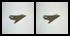

 10%|▉         | 973/10000 [00:03<00:28, 316.44it/s]

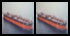

 15%|█▍        | 1494/10000 [00:04<00:26, 322.96it/s]

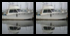

 20%|█▉        | 1988/10000 [00:06<00:25, 310.33it/s]

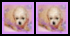

 25%|██▍       | 2487/10000 [00:07<00:23, 325.77it/s]

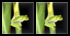

 30%|██▉       | 2983/10000 [00:09<00:22, 312.32it/s]

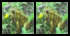

 35%|███▍      | 3469/10000 [00:10<00:20, 319.58it/s]

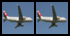

 40%|███▉      | 3988/10000 [00:12<00:19, 316.39it/s]

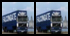

 45%|████▍     | 4474/10000 [00:14<00:17, 307.04it/s]

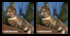

 50%|████▉     | 4992/10000 [00:15<00:15, 315.80it/s]

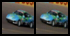

 55%|█████▍    | 5477/10000 [00:17<00:14, 322.00it/s]

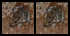

 60%|█████▉    | 5999/10000 [00:18<00:12, 320.50it/s]

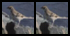

 65%|██████▍   | 6489/10000 [00:20<00:11, 308.33it/s]

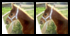

 70%|██████▉   | 6975/10000 [00:22<00:09, 314.18it/s]

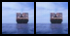

 75%|███████▍  | 7490/10000 [00:23<00:08, 310.06it/s]

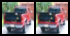

 80%|███████▉  | 7971/10000 [00:25<00:06, 306.24it/s]

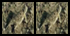

 85%|████████▍ | 8491/10000 [00:26<00:04, 320.63it/s]

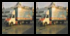

 90%|████████▉ | 8980/10000 [00:28<00:03, 321.40it/s]

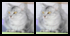

 95%|█████████▍| 9485/10000 [00:30<00:01, 308.58it/s]

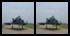

100%|█████████▉| 9996/10000 [00:31<00:00, 299.88it/s]

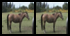

100%|██████████| 10000/10000 [00:31<00:00, 313.68it/s]



MSE :0.0001, PSNR: :42.4769, SSIM: :0.9972




In [43]:
# Testing 

#Please change accordingly

#uncomment if downloaded a pretrained model
model.load_state_dict(torch.load('./PretrainModels/AE_model_50.pth'))
# model.load_state_dict(torch.load('./PretrainModels/2DecodersSSIM_epoch400.pth'))

#uncomment if not downloaded a pretrained model
# model.load_state_dict(torch.load('./PretrainModels/AE_model_1.pth'))


model.eval()


#initialization
Evaluate(test_dataloader, model, True)

